In [55]:
import os
import numpy as np
from scipy.ndimage import distance_transform_edt
from edit_annotation_tiles import edit_annotations_tiles
from load_annotation_data import load_annotation_data
from PIL import Image
from skimage.morphology import disk, dilation
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

In [56]:
# Pre - inputs
pth = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model'
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024'
pthim_ann = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\5x'
classcheck = 0
datafile = r'\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024\net.pkl'

In [57]:
# Inputs 
import pickle
with open(datafile, 'rb') as f:
    data = pickle.load(f)
nblack = data['nblack']
sxy = data['sxy']
ctlist0, numann0 = load_annotation_data(pthDL, pth, pthim_ann,classcheck)
numann0 = np.array(numann0)  # Convert numann0 to a NumPy array

numann = numann0.copy()
percann = np.double(numann0 > 0)
percann = np.dstack((percann, percann))
percann0 = percann.copy()
stile = None 
nbg = None

outpth = r'training'


 
Importing annotation data...
Image 1 of 2: SG_013_0061
 annotation data previously loaded
Image 2 of 2: SG_014_0016
 annotation data previously loaded


In [58]:
if nbg is None:
        nbg = 0
if stile is None:
    stile = 10000
stile += 200
kpall = 1


In [59]:
# Define folder locations
outpthim = os.path.join(pthDL, outpth, 'im/')
outpthlabel = os.path.join(pthDL, outpth, 'label/')
outpthbg = os.path.join(pthDL, outpth, 'big_tiles/')
os.makedirs(outpthim, exist_ok=True)
os.makedirs(outpthlabel, exist_ok=True)
os.makedirs(outpthbg, exist_ok=True)

In [60]:
imlistck = [f for f in os.listdir(outpthim) if f.endswith('.tif')]
nm0 = len(imlistck) + 1

In [97]:
# Create very large blank images - NO IDEA WHAT THESE VARIABLES ARE
imH = np.full((stile, stile, 3), nbg, dtype=np.double) #create an array with the specified dimensions with the value of ngb
imT = np.zeros((stile, stile)) #blank mask
nL = imT.size # size of the big tile
ct = np.zeros(numann.shape[1]) # list (size of how many annotations you have)
sf = np.sum(ct) / nL # how full is the big tile

In [62]:
count = 1
tcount = 0 #is not one because of python indexing starts at 0
cutoff = 0.55 # Cut off for how full the big tile is (55% full)
rsf = 5
type0 = 1
h = np.ones((51, 51))
h[25, 25] = 0
h = distance_transform_edt(h) < 26

In [63]:
#__________ This should be the iteration of a  while loop__________
# choose one of each class in order in a loop
if count % 10 == 1:
    type_ = tcount
    tcount = (tcount % len(ct)) + 1
# choose a tile containing the least prevalent class
else:
    tmp = np.sum(ct, axis=0).copy()  # Create a copy of the array
    tmp[type0] = np.max(tmp)
    type_ = np.argmin(tmp)
    
num = np.where(numann[:, type_] > 0)[0]

if len(num) == 0:
    numann[:, type_] = numann0[:, type_]
    num = np.where(numann[:, type_] > 0)[0]
num = np.random.choice(num, size=1, replace=False)


In [68]:

# load annotation and mask
tile_name = ctlist0['tile_name'][num[0]] 
# USE THIS LINE IN THE FUNCTION, FOR REPRODUCIBILITY WE WILL USE A FIXED TILE NAME
tile_name = '00022.tif' # 00240 in matlab
print(tile_name)
tile_path = os.path.join(ctlist0['tile_pth'][num[0]], tile_name)
pf = tile_path.rfind('\\', 0 ,tile_path.rfind('\\'))
pthlabel = os.path.join(tile_path[0:pf], 'label')
print(pthlabel)

00022.tif
\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\data\SG_014_0016\04_19_2024_boundbox\label


In [69]:
im = np.array(Image.open(tile_path))
TA = np.array(Image.open(os.path.join(pthlabel, tile_name)))

Text(0.5, 1.0, '00022.tif pre augmentation')

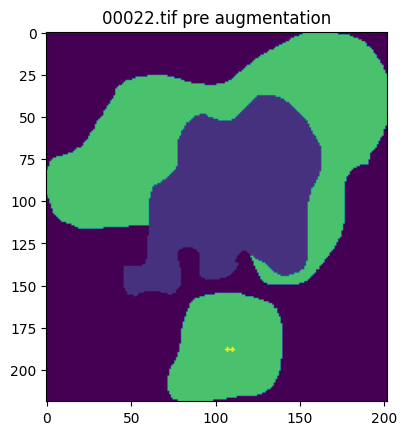

In [70]:
plt.imshow(TA)
plt.title(tile_name + ' pre augmentation')

In [71]:
doaug = (count % 3 == 1)
im, TA, kp = edit_annotations_tiles(im, TA, doaug, type_, ct, imT.shape[0], kpall)  
numann[num, kp-1] = 0 #kp-1 due to layer index starting in 1 and python index starting in 0
percann[num, kp-1, 0] += 1
percann[num, kp-1, 1] = 2
fx = (TA != 0)
if np.sum(fx) < 30:
    print('skipped')
    #continue

Text(0.5, 1.0, '00022.tif post augmentation')

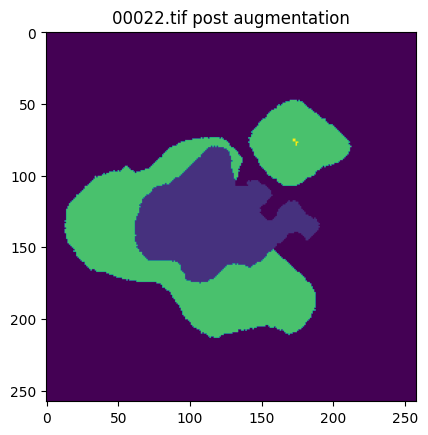

In [72]:
plt.imshow(TA) # checked jaime's code in here!!!!
plt.title(tile_name + ' post augmentation')

In [87]:
 # find low density location in large tile to add annotation
tmp = imT > 0
tmp2 = tmp[::rsf, ::rsf]
tmp2 = convolve(tmp2.astype(float), h, mode='constant', cval=0.0)
tmp = distance_transform_edt(tmp2 == 0)
tmp[:19, :] = 0
tmp[-20:, :] = 0
tmp[:, :19] = 0
tmp[:, -20:] = 0
xii = np.argmax(tmp)
xii = np.random.choice(xii, size=1, replace=False)
x, y = np.unravel_index(xii, tmp.shape)

x = int(x * rsf)
y = int(y * rsf)

szz = np.array(TA.shape) - 1
szzA = szz // 2
szzB = szz - szzA

# Ensure szzA and szzB are tuples of integers to be used for slicing afterwards
szzA = tuple(map(int, szzA))
szzB = tuple(map(int, szzB))

In [88]:
if x + szzA[0] > imT.shape[1]:
    x -= szzA[0]
if y + szzA[1] > imT.shape[0]:
    y -= szzA[1]
if x - szzB[0] < 0:
    x += szzB[0]
if y - szzB[1] < 0:
    y += szzB[1]

In [89]:
tmpT = imT[x - szzB[0]:x + szzA[0] + 1, y - szzB[1]:y + szzA[1] + 1].copy()
tmpT[fx] = TA[fx]
tmpH = imH[x - szzB[0]:x + szzA[0] + 1, y - szzB[1]:y + szzA[1] + 1, :].copy()
tmpH[np.dstack((fx, fx, fx))] = im[np.dstack((fx, fx, fx))]
imT[x - szzB[0]:x + szzA[0] + 1, y - szzB[1]:y + szzA[1] + 1] = tmpT
imH[x - szzB[0]:x + szzA[0] + 1, y - szzB[1]:y + szzA[1] + 1, :] = tmpH

In [90]:
# Update total count
if count % 2 == 0:
    sf = np.sum(imT > 0) / nL  # print(f"{count} {round(sf * 100)}")

for p in range(numann.shape[1]):
    ct[p] += np.sum(tmpT == p)

if count % 150 == 0 or sf > cutoff:
    tmp = np.histogram(imT, bins=np.arange(numann.shape[1] + 2))[0]
    ct = tmp[1:]
    ct[ct == 0] = 1

count += 1
type0 = type_

In [92]:
 # cut edges off tile
imH = imH[100:-100, 100:-100, :].astype(np.uint8)
imT = imT[100:-100, 100:-100].astype(np.uint8)

for p in range(nblack-1): # the '-1' has to do with python indxing 
    ct[p] = np.sum(imT == p)
    
imT[imT == 0] = nblack

In [93]:
# save cutouts to outpth
sz = imH.shape
for s1 in range(0, sz[0], sxy):
    for s2 in range(0, sz[1], sxy):
        try:
            imHtmp = imH[s1:s1 + sxy, s2:s2 + sxy, :]
            imTtmp = imT[s1:s1 + sxy, s2:s2 + sxy]
        except ValueError:
            continue

        Image.fromarray(imHtmp).save(os.path.join(outpthim, f"{nm0}.tif"))
        Image.fromarray(imTtmp).save(os.path.join(outpthlabel, f"{nm0}.tif"))
        nm0 += 1   

In [95]:
nm1 = len([f for f in os.listdir(outpthbg) if f.startswith('HE')]) + 1

In [96]:
# save large tiles
Image.fromarray(imH).save(os.path.join(outpthbg, f"HE_tile_{nm1}.jpg"))
Image.fromarray(imT).save(os.path.join(outpthbg, f"label_tile_{nm1}.jpg"))

In [94]:
print(os.path.join(outpthim, f"{nm0}.tif"))


\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\04_19_2024\training\im/101.tif


In [8]:
%reset

In [109]:
with open(datafile, 'rb') as f:
    data = pickle.load(f)
pth = data['pthim']
print(pth)

\\10.99.68.52\Kiemendata\Valentina Matos\coda to python\test model\5x


In [33]:
%reset

In [2]:

for count in range(100):
    rem = count % 10
    print(f'{count} {rem+1}')

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 1
11 2
12 3
13 4
14 5
15 6
16 7
17 8
18 9
19 10
20 1
21 2
22 3
23 4
24 5
25 6
26 7
27 8
28 9
29 10
30 1
31 2
32 3
33 4
34 5
35 6
36 7
37 8
38 9
39 10
40 1
41 2
42 3
43 4
44 5
45 6
46 7
47 8
48 9
49 10
50 1
51 2
52 3
53 4
54 5
55 6
56 7
57 8
58 9
59 10
60 1
61 2
62 3
63 4
64 5
65 6
66 7
67 8
68 9
69 10
70 1
71 2
72 3
73 4
74 5
75 6
76 7
77 8
78 9
79 10
80 1
81 2
82 3
83 4
84 5
85 6
86 7
87 8
88 9
89 10
90 1
91 2
92 3
93 4
94 5
95 6
96 7
97 8
98 9
99 10
